# LangChain QA Panel App

This notebook shows how to make this app:

In [81]:
pip install langchain openai chromadb tiktoken pypdf panel


Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [83]:
import os 
from langchain import chains 
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain import document_loaders 
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain import indexes 
from langchain.indexes import VectorstoreIndexCreator
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings  import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import re
import panel as pn
import tempfile

In [84]:
# Initialize Panels
pn.extension('texteditor', template="bootstrap", sizing_mode='stretch_width')
pn.state.template.param.update(
    title="Welcome to JP Morgan Metaverse",
    main_max_width="690px",
    header_background="#1e81b0",
    logo="jpmorgan-chase-co-logo.png"  
)

In [85]:
# CSS
custom_style = {
    'width': '1700px',
    'height': '2000px',
    'margin-top': '-20px',
    'background': '#94bad4',
    'border': '1px solid black',
    'margin-left': '-450px',
    'padding': '10px',
    'box-shadow': '10px 10px 10px #bcbcbc',
    'size': '10px'
}
convo_style = {
    'margin-left': '500px',
    'margin-top': '-700px',
    'border': '0'
}
markdown_style = {
    'font-family': 'Georgia',
    'color': 'black',
    'text-align': 'center',
    'font-size': '20px'
}
widget_style = {
    'margin-top': '65px',
    'margin-left': '70px',
    'border': '5px solid white',
    'width': '1500px'
}
textbox_style = {
    'border': '1px solid white',
    'border-radius': '25px',
    'background': '#C0C0C0',
    'font-color': 'white'
}
row_styles = {
    'margin-top': '1000px',
    'position': 'fixed'
}
avatar_style = {
    'margin-left': '-300px'
}
card_style = {
    'margin-top': '3px',
    'height': '50px',
    'color': 'white',
    'visibility': 'hidden'
}
row_style={
    'margin-top': '0px',
    'margin-left': '180px',
    'height': '50px'
}
input_style = {
    'border-radius': '25px',
    'border': '2px solid black',
    'font-color': 'black',
    'background': 'white',
} 
output_style = {
    'border-radius': '25px',
    'border': '2px solid white',
    'background': 'black',
    'color': 'white',
    'margin-left': '200px',
    'width': '1000px'
}
space_style = {
    'height': '5px'
}
chat_bot_style = {
    'border': '0',
    'margin-top': '-50px',
    'background': '#94bad4',
    'background-repeat': 'no-repeat',
    'background-size': '100%'
}
button_style = {
    'background': '#046eae',
    'border': '2px solid white',
    'border-radius': '25px',
    'margin-top': '4px'
}
upload_style = {
    'margin-left': '2px',
    'width': '10px'
}
file_style = {
    'margin-left': '-4px'
}

In [86]:
#UI elements
file_input = pn.widgets.FileInput(width=270)
openaikey = pn.widgets.PasswordInput(
    value="", placeholder="Enter your OpenAI API Key here...", width=300
)

prompt = pn.widgets.TextEditor(
    value="", placeholder="Enter your questions here...", height=50,width=755, toolbar=False, styles = textbox_style 
)
run_button = pn.widgets.Button(name=' Send Message',button_type='primary',icon='brand-telegram', height=40,width=50)
button_row = pn.Row(run_button,height=52,width=160,styles = button_style)
select_k = pn.widgets.IntSlider(
    name="Number of relevant chunks", start=1, end=5, step=1, value=2
)
select_chain_type = pn.widgets.RadioButtonGroup(
    name='Chain type', 
    options=['stuff', 'map_reduce', "refine", "map_rerank"]
)
text_to_speech = pn.widgets.TextToSpeech(name="Text to Speech Widget",auto_speak=True, volume=0.5)

widgets = pn.Row(prompt,margin=5)

In [87]:
# Main functionality to call LangChain API
def qa(file, query, chain_type, k):
    # load document
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split the documents into chunks
    text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
    texts = text_splitter.split_documents(documents)
    # select which embeddings we want to use
    embeddings = OpenAIEmbeddings()
    # create the vectorestore to use as the index
    db = Chroma.from_documents(texts, embeddings)
    # expose this index in a retriever interface
    # Pass two own query search strings (eg : First Name, Last Name)
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chain to answer questions 
    qa = RetrievalQA.from_chain_type(
        llm=OpenAI(), chain_type=chain_type, retriever=retriever, return_source_documents=True)
    result = qa({"query": query})
    return result

In [88]:
# result = qa("GlobalCustodyAgreement.pdf", "what is the total number of AI publications?")

In [89]:
convos = []  # store all panel objects in a list
ai_png = pn.pane.Image('Ellipse.png', width=40)
user_png = pn.pane.Image('user.png', width=40)
avatar_png = pn.pane.Image('lady-avatar.png',width=500,height=800) 

verify_queries = "What is the Account Contact Name?"\
    "What is the Account Contact Address?"\
    "What is the Client Contact Name?"\
    "What is the Client Contact Telephone?"\
    "What is the Client Contact Email?"\
    "What is the Legal Entity Name?"\
    "What is the Legal Entity Identifier?"\
    "What is the Tax Identifier?"

def qa_result(_):
    # API Key from Account
    os.environ["OPENAI_API_KEY"] = ""
    
    #Change index here to change the default voice to whatever voice you want.
    #To get index of voice, uncomment below line of code to print a list of voices.
    
    
    # If file is inputted.
    if file_input.value is not None:
        #print(text_to_speech.voices)
        file_input.save("example.pdf")
        prompt_text = prompt.value
        
        # When User initally uploads file. AI will retrieved info from document and display summary.
        if "Uploaded" in re.sub('<[^<]+?>', '', prompt_text) or "Here" in re.sub('<[^<]+?>', '', prompt_text):
            result = qa(file="example.pdf", query=verify_queries, chain_type=select_chain_type.value, k=select_k.value)
            query_result = verify_doc(result["result"])
            convos.extend(add_conversation(prompt_text, query_result, True))
            #text_to_speech.voice = text_to_speech.voices[34]
            text_to_speech.value = "Great. I was able to get most of the information I need. Could you please validate the information I have pulled up about the funds?"
        
        # AI Conversation Answers    
        elif "Yes" in re.sub('<[^<]+?>', '', prompt_text) or "Everything" in re.sub('<[^<]+?>', '', prompt_text) or "Thank" in re.sub('<[^<]+?>', '', prompt_text):
            prompt_text = prompt.value
            result = get_answer((re.sub('<[^<]+?>', '', prompt.value)))
            convos.extend(add_conversation(prompt_text, result, False))
            #text_to_speech.voice = text_to_speech.voices[34]
            text_to_speech.value = result
            
        # Any other queries to AI    
        else:
            result = qa(file="example.pdf", query=prompt_text, chain_type=select_chain_type.value, k=select_k.value)
            convos.extend(add_conversation(prompt_text, result["result"], False))
            #text_to_speech.voice = text_to_speech.voices[34]
            text_to_speech.value = re.sub('<[^<]+?>', '', result["result"])
    
    ## If no document is inputted.
    elif prompt.value:
        #print(text_to_speech.voices)
        prompt_text = prompt.value
        result = get_answer((re.sub('<[^<]+?>', '', prompt.value)))
        convos.extend(add_conversation(prompt_text, result, False))
        #text_to_speech.voice = text_to_speech.voices[34]
        text_to_speech.value = result
    prompt.value = ""
    return convos
    return pn.Column(*convos, margin=15, width=575, min_height=400)


In [90]:
# Convos QA dictionary.
qa_dict = {
    "Hi": "Hi, I'm Elara. How can I help you today?",
    "Hi Elara, I am existing client.I am looking to onboard to TIM": "Sure. Do you have your TIM Agreement so I can pull up relevant information?",
    "Yes, I have the document.": "Could you please upload?",
    "Everything looks good": "Great, I'll need a bit more information to complete the process. Shall we proceed?",
    "Yes": "Will you use the same account for using TIM?",
    "Yes, please": "Thank you. We are all set. Do you have any questions for me?",
    "Thank you": "If no further questions, you should be receiving a notification from us within 24 hours with your new account numbers. Have a nice day!"
    #what is the termination policy?
    #what is the policy on Proprietary information and Client Data?
}

# The headers for the verifying document details.
doc_details = [
    "<p><b>Custodian Contact Name:</b> ",
    "<p><b>Custodian Contact Address:</b> ",
    "<p><b>Client Contact Name:</b> ",
    "<p><b>Client Contact Telephone:</b> ",
    "<p><b>Client Contact Email:</b> ",
    "<p><b>Legal Entity Name:</b> ",
    "<p><b>Legal Entity Identifier:</b> ",
    "<p><b>Tax Identifier:</b> "
]

# Function for retrieving answers for a question.
def get_answer(question):
    if question in qa_dict:
        return qa_dict[question]
    else:
        return "I'm sorry, I don't have an answer to that question."
    
# Function for parsing the AI response and displaying details.    
def verify_doc(result):
    format_result = "<p>Great. I was able to get most of the information I need.</p>"
    result_arr = result.split(". ")
    if len(result_arr) != 1:
        i = 0
        for ans in result_arr:
            parse_ans = ans.split("is")
            format_result += doc_details[i]
            format_result += parse_ans[1]
            format_result += "</p>"
            i+=1
    elif len(result.split("\n")) != 1:
        result_arr = result.split("\n")
        result_arr = result_arr[1:]
        i = 0
        for ans in result_arr:
            parse_ans = ans.split(":")
            format_result += doc_details[i]
            format_result += parse_ans[1]
            format_result += "</p>"
            i+=1
    else:
        format_result += result
    return format_result

# Helper function to add the chat responses. 
def add_conversation(prompt_text, chat_result, is_verify):
    if is_verify == False:
        return[
                pn.Row(
                    pn.panel(user_png, width=10),
                    prompt_text,
                    width=600,
                    styles = input_style
                ),
                pn.Row(styles= space_style),
                pn.Row(
                    pn.panel(ai_png, width=10),
                    pn.Column(chat_result),
                    styles = output_style
                ),
                pn.Row(styles= space_style),
            ]
    else:
        return[
                pn.Row(
                    pn.panel(user_png, width=10),
                    prompt_text,
                    width=600,
                    styles = input_style
                ),
                pn.Row(styles= space_style),
                pn.Row(
                    pn.panel(ai_png, width=10),
                    pn.Column(
                        chat_result),
                    styles = output_style
                ),
                pn.Row(styles= space_style),
                pn.Row(
                    pn.panel(ai_png, width=10),
                    pn.Column(
                        "<p>Could you please validate the information I have pulled up about the funds?</p>"),
                    styles = output_style
                ),
                pn.Row(styles= space_style),
            ]
    

In [91]:
qa_interactive = pn.panel(
    pn.bind(qa_result, run_button),
    loading_indicator=True,
)

FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=False, device_pixel_ratio=2, language='en-GB', timezone='Europe/London', timezone_offset=-60, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-5521343568] Column(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] Column(sizing_mode='stretch_width', styles={'width': '1700px', ...})
            [0] Image(str, height=800, sizing_mode='fixed', width=500)
            [1] Column(sizing_mode='stretch_width', styles={'margin-left': '500px', ...})
                [0] Row(sizing_mode='stretch_width', styles={'margin-top': '0px', ...})
                    [0] FileInput(width=270)
                    [1] Row(height=52, sizing_mode='fixed', styles={'background': '#046eae', ...}, width=160)
                        [0] Button(button_type='primary', height=40, icon='brand-telegram', name=' Send Message', sizing_mode='fixed', width=50)
                    [2] Card(collapsed=True, styles={'margin-top': '3px', ...}, title='Voice Settings', width=180)
                        [0] Tabs(sizing_mode='stretch_width')
                            [0] WidgetBox(margin=(5, 10), name='Controls', sizing_mode='stretch_width')
                                [0] StaticText(sizing_mode='stretch_width', value='<b>Controls</b>')
                                [1] Checkbox(name='Disabled', sizing_mode='stretch_width')
                                [2] TextInput(description='The text that will be syn..., name='Value', sizing_mode='stretch_width')
                                [3] Select(description='The language o..., name='Lang', options=OrderedDict([('en-US', ...]), sizing_mode='stretch_width', value='en-US')
                                [4] FloatSlider(end=2.0, name='Pitch', sizing_mode='stretch_width', value=1.0)
                                [5] FloatSlider(end=10.0, name='Rate', sizing_mode='stretch_width', start=0.1, value=1.0)
                                [6] Select(description='The voice that w..., name='Voice', sizing_mode='stretch_width')
                                [7] FloatSlider(name='Volume', sizing_mode='stretch_width', value=0.5)
                                [8] Checkbox(name='Auto speak', sizing_mode='stretch_width', value=True)
                                [9] Button(description='Removes all u..., name='Cancel', sizing_mode='stretch_width')
                                [10] Button(description='Puts the TextToSpeak o..., name='Pause', sizing_mode='stretch_width')
                                [11] Button(description='Puts the TextToSpeak o..., name='Resume', sizing_mode='stretch_width')
                                [12] Checkbox(name='Paused', sizing_mode='stretch_width')
                                [13] Checkbox(name='Pending', sizing_mode='stretch_width')
                                [14] Button(description='Speak. I.e. s..., name='Speak', sizing_mode='stretch_width')
                                [15] Checkbox(name='Speaking', sizing_mode='stretch_width')
                                [16] ListInput(description='Returns a list o..., name='Voices', sizing_mode='stretch_width', type=<class 'list'>)
                                [17] ListInput(name=' voices', sizing_mode='stretch_width', type=<class 'list'>)
                            [1] WidgetBox(margin=(5, 10), name='Layout', sizing_mode='stretch_width')
                                [0] StaticText(sizing_mode='stretch_width', value='<b>Layout</b>')
                                [1] TextInput(description='String identifier f..., name='Name', sizing_mode='stretch_width', value='Text to Speech Widget')
                                [2] LiteralInput(description='Whether the object should..., name='Align', sizing_mode='stretch_width', value='start')
                                [3] LiteralInput(descripti
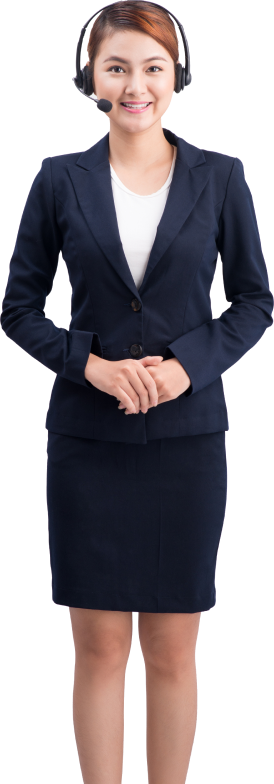

In [92]:
# layout
voicesettings = pn.Card(
    text_to_speech.controls(jslink=False),
    text_to_speech,
    title="Voice Settings",
    collapsed = True,
    width=180,
    styles = card_style
    )

fileinput = pn.Row(file_input,button_row,voicesettings, styles=row_style)

main_area = pn.Column(
    pn.pane.Markdown("""
    ## Elara Banking AI
    """),
    pn.Column(avatar_png,
    pn.Column( 
    fileinput,
    widgets,
    styles=convo_style
    ), styles=custom_style).servable())

template = pn.template.FastListTemplate(
   title = 'ARIA',
   main = [main_area],
)
template.servable()

In [93]:
chat_box = pn.WidgetBox(qa_interactive, width=800, height=500,styles = chat_bot_style, scroll=True)